In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
!curl -L -o /content/data/celebahq-resized-256x256.zip "https://www.kaggle.com/api/v1/datasets/download/badasstechie/celebahq-resized-256x256"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  283M  100  283M    0     0  17.1M      0  0:00:16  0:00:16 --:--:-- 19.0M


In [ ]:
!unzip /content/data/celebahq-resized-256x256.zip -d /content/data/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/data/celeba_hq_256/25000.jpg  
  inflating: /content/data/celeba_hq_256/25001.jpg  
  inflating: /content/data/celeba_hq_256/25002.jpg  
  inflating: /content/data/celeba_hq_256/25003.jpg  
  inflating: /content/data/celeba_hq_256/25004.jpg  
  inflating: /content/data/celeba_hq_256/25005.jpg  
  inflating: /content/data/celeba_hq_256/25006.jpg  
  inflating: /content/data/celeba_hq_256/25007.jpg  
  inflating: /content/data/celeba_hq_256/25008.jpg  
  inflating: /content/data/celeba_hq_256/25009.jpg  
  inflating: /content/data/celeba_hq_256/25010.jpg  
  inflating: /content/data/celeba_hq_256/25011.jpg  
  inflating: /content/data/celeba_hq_256/25012.jpg  
  inflating: /content/data/celeba_hq_256/25013.jpg  
  inflating: /content/data/celeba_hq_256/25014.jpg  
  inflating: /content/data/celeba_hq_256/25015.jpg  
  inflating: /content/data/celeba_hq_256/25016.jpg  
  inflating: /content/data/celeba_hq_256/25017.jpg  

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
!pip uninstall ldm

Found existing installation: ldm 0.1.3
Uninstalling ldm-0.1.3:
  Would remove:
    /usr/local/lib/python3.12/dist-packages/ldm-0.1.3.dist-info/*
    /usr/local/lib/python3.12/dist-packages/ldm.py
Proceed (Y/n)? y
  Successfully uninstalled ldm-0.1.3


In [ ]:
!pip install taming-transformers-rom1504

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.2/829.2 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 65.1 MB/s eta 0:00:00


In [ ]:
from diffusers import UNet2DModel, DDIMScheduler, VQModel
vae = VQModel.from_pretrained("CompVis/ldm-celebahq-256", subfolder="vqvae")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

An error occurred while trying to fetch CompVis/ldm-celebahq-256: CompVis/ldm-celebahq-256 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


vqvae/diffusion_pytorch_model.bin:   0%|          | 0.00/221M [00:00<?, ?B/s]

In [ ]:
import os
import csv

def save_png_filenames_to_csv(folder_path, output_csv_path):
    # .png uzantılı dosyaları al
    png_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]

    # CSV'ye yaz
    with open(output_csv_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['filename'])
        for file in png_files:
            writer.writerow([file])

    print(f"{len(png_files)} .png dosyası CSV'ye kaydedildi: {output_csv_path}")

In [ ]:
save_png_filenames_to_csv(
    folder_path='/content/data/celeba_hq_256/',
    output_csv_path='/content/output_filenames.csv'
)

30000 .png dosyası CSV'ye kaydedildi: /content/output_filenames.csv


In [ ]:
df = pd.read_csv("/content/output_filenames.csv")

train_df, val_df = train_test_split(df,train_size=0.9, test_size=0.1, random_state=42)

In [ ]:
from diffusers import UNet2DModel

unet = UNet2DModel(
    sample_size=64,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(224, 224*2, 224*3, 224*4),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D"
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D"
    ),
    attention_head_dim=32
).to(device)

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

class ImageDataset(Dataset):
    """
    Dataset that loads images specified in a DataFrame and returns image tensor + random diffusion timestep.

    Args:
        df (pandas.DataFrame): DataFrame with a column 'filename' listing image file names.
        image_dir (str): Directory where images are stored.
        t_max (int): Maximum diffusion timesteps (exclusive).
        transform (callable, optional): torchvision transforms to apply to PIL images.
    """
    def __init__(
        self,
        df,
        image_dir,
        t_max: int = 1000,
        transform=None,
    ):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.t_max = t_max
        self.transform = transform or transforms.Compose([
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        fname = self.df.iloc[idx]['filename']
        img_path = os.path.join(self.image_dir, fname)

        # Load and transform image
        img = Image.open(img_path).convert('RGB')
        x = self.transform(img)

        # Random diffusion timestep
        t = torch.randint(int(0), int(t_max), (1,)).item()


        return x, t

In [ ]:
!PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [ ]:
image_dir = "/content/data/celeba_hq_256/"
t_max = 1000

train_ds = ImageDataset(
    df=train_df,
    image_dir=image_dir,
    t_max=t_max
)
val_ds = ImageDataset(
    df=val_df,
    image_dir=image_dir,
    t_max=t_max
)



train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
val_loader = DataLoader(
    val_ds,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [ ]:
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
from diffusers import DDPMScheduler
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet = unet.to(device)
vae  = vae.to(device).eval()

mse_criterion = nn.MSELoss()

optimizer = optim.AdamW(unet.parameters(), lr=9.6e-5)

num_epochs = 60
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=25,
    eta_min=1e-5
)

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="linear"
)

scaler = torch.amp.GradScaler("cuda")

best_val_loss = float("inf")


for epoch in range(1, num_epochs + 1):
    unet.train()
    train_loss = 0.0

    for x, t in tqdm(train_loader, desc=f"[Train] Epoch {epoch}/{num_epochs}"):
        x = x.to(device)
        t = t.to(device)

        with torch.no_grad():
            enc = vae.encode(x)
            z0  = enc[0]
        noise = torch.randn_like(z0)
        x_t   = noise_scheduler.add_noise(z0, noise, timesteps=t)

        optimizer.zero_grad()
        with torch.amp.autocast("cuda"):
            noise_pred = unet(x_t, timestep=t).sample
            loss = mse_criterion(noise_pred, noise)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * x.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f"\n✅ Epoch {epoch} Train Loss: {avg_train_loss:.4f}")

    unet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, t in tqdm(val_loader, desc=f"[Valid] Epoch {epoch}/{num_epochs}"):
            x = x.to(device)
            t = t.to(device)

            enc = vae.encode(x)
            z0  = enc[0]

            noise = torch.randn_like(z0)
            x_t   = noise_scheduler.add_noise(z0, noise, timesteps=t)

            with torch.amp.autocast("cuda"):
                noise_pred = unet(x_t, timestep=t).sample
                val_loss += mse_criterion(noise_pred, noise).item() * x.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"📉 Validation Loss: {avg_val_loss:.4f}")

    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"🔄 Updated LR: {current_lr:.6f}")

    save_path = f"/content/drive/MyDrive/ddpm{epoch}.pt"
    torch.save(unet.state_dict(), save_path)
    print(f"💾 Model saved: {save_path}\n")

[Train] Epoch 1/60: 100%|██████████| 844/844 [06:42<00:00,  2.10it/s]



✅ Epoch 1 Train Loss: 0.1878


[Valid] Epoch 1/60: 100%|██████████| 375/375 [00:33<00:00, 11.36it/s]


📉 Validation Loss: 0.1708
🔄 Updated LR: 0.000096
💾 Model saved: /content/drive/MyDrive/ddpm1.pt



[Train] Epoch 2/60: 100%|██████████| 844/844 [06:42<00:00,  2.10it/s]



✅ Epoch 2 Train Loss: 0.1675


[Valid] Epoch 2/60: 100%|██████████| 375/375 [00:33<00:00, 11.35it/s]


📉 Validation Loss: 0.1605
🔄 Updated LR: 0.000095
💾 Model saved: /content/drive/MyDrive/ddpm2.pt



[Train] Epoch 3/60: 100%|██████████| 844/844 [06:42<00:00,  2.10it/s]



✅ Epoch 3 Train Loss: 0.1639


[Valid] Epoch 3/60: 100%|██████████| 375/375 [00:33<00:00, 11.36it/s]


📉 Validation Loss: 0.1624
🔄 Updated LR: 0.000093
💾 Model saved: /content/drive/MyDrive/ddpm3.pt



[Train] Epoch 4/60: 100%|██████████| 844/844 [06:42<00:00,  2.09it/s]



✅ Epoch 4 Train Loss: 0.1625


[Valid] Epoch 4/60: 100%|██████████| 375/375 [00:33<00:00, 11.36it/s]


📉 Validation Loss: 0.1551
🔄 Updated LR: 0.000091
💾 Model saved: /content/drive/MyDrive/ddpm4.pt



[Train] Epoch 5/60: 100%|██████████| 844/844 [06:42<00:00,  2.10it/s]



✅ Epoch 5 Train Loss: 0.1615


[Valid] Epoch 5/60: 100%|██████████| 375/375 [00:33<00:00, 11.36it/s]


📉 Validation Loss: 0.1556
🔄 Updated LR: 0.000088
💾 Model saved: /content/drive/MyDrive/ddpm5.pt



[Train] Epoch 6/60: 100%|██████████| 844/844 [06:42<00:00,  2.10it/s]



✅ Epoch 6 Train Loss: 0.1571


[Valid] Epoch 6/60: 100%|██████████| 375/375 [00:33<00:00, 11.36it/s]


📉 Validation Loss: 0.1626
🔄 Updated LR: 0.000084
💾 Model saved: /content/drive/MyDrive/ddpm6.pt



[Train] Epoch 7/60: 100%|██████████| 844/844 [06:42<00:00,  2.10it/s]



✅ Epoch 7 Train Loss: 0.1565


[Valid] Epoch 7/60: 100%|██████████| 375/375 [00:32<00:00, 11.37it/s]


📉 Validation Loss: 0.1615
🔄 Updated LR: 0.000080
💾 Model saved: /content/drive/MyDrive/ddpm7.pt



[Train] Epoch 8/60: 100%|██████████| 844/844 [06:42<00:00,  2.10it/s]



✅ Epoch 8 Train Loss: 0.1568


[Valid] Epoch 8/60: 100%|██████████| 375/375 [00:33<00:00, 11.36it/s]


📉 Validation Loss: 0.1607
🔄 Updated LR: 0.000076
💾 Model saved: /content/drive/MyDrive/ddpm8.pt



[Train] Epoch 9/60: 100%|██████████| 844/844 [06:42<00:00,  2.10it/s]



✅ Epoch 9 Train Loss: 0.1560


[Valid] Epoch 9/60: 100%|██████████| 375/375 [00:32<00:00, 11.37it/s]


📉 Validation Loss: 0.1511
🔄 Updated LR: 0.000071
💾 Model saved: /content/drive/MyDrive/ddpm9.pt



[Train] Epoch 10/60: 100%|██████████| 844/844 [06:42<00:00,  2.09it/s]



✅ Epoch 10 Train Loss: 0.1546


[Valid] Epoch 10/60: 100%|██████████| 375/375 [00:32<00:00, 11.36it/s]


📉 Validation Loss: 0.1547
🔄 Updated LR: 0.000066
💾 Model saved: /content/drive/MyDrive/ddpm10.pt



[Train] Epoch 11/60: 100%|██████████| 844/844 [06:42<00:00,  2.10it/s]



✅ Epoch 11 Train Loss: 0.1574


[Valid] Epoch 11/60: 100%|██████████| 375/375 [00:33<00:00, 11.36it/s]


📉 Validation Loss: 0.1649
🔄 Updated LR: 0.000061
💾 Model saved: /content/drive/MyDrive/ddpm11.pt



[Train] Epoch 12/60: 100%|██████████| 844/844 [06:42<00:00,  2.10it/s]



✅ Epoch 12 Train Loss: 0.1544


[Valid] Epoch 12/60: 100%|██████████| 375/375 [00:33<00:00, 11.36it/s]


📉 Validation Loss: 0.1544
🔄 Updated LR: 0.000056
💾 Model saved: /content/drive/MyDrive/ddpm12.pt



[Train] Epoch 13/60: 100%|██████████| 844/844 [06:42<00:00,  2.09it/s]



✅ Epoch 13 Train Loss: 0.1512


[Valid] Epoch 13/60: 100%|██████████| 375/375 [00:32<00:00, 11.37it/s]


📉 Validation Loss: 0.1500
🔄 Updated LR: 0.000050
💾 Model saved: /content/drive/MyDrive/ddpm13.pt



[Train] Epoch 14/60: 100%|██████████| 844/844 [06:42<00:00,  2.10it/s]



✅ Epoch 14 Train Loss: 0.1531


[Valid] Epoch 14/60: 100%|██████████| 375/375 [00:33<00:00, 11.35it/s]


📉 Validation Loss: 0.1461
🔄 Updated LR: 0.000045
💾 Model saved: /content/drive/MyDrive/ddpm14.pt



[Train] Epoch 15/60: 100%|██████████| 844/844 [06:42<00:00,  2.10it/s]



✅ Epoch 15 Train Loss: 0.1521


[Valid] Epoch 15/60: 100%|██████████| 375/375 [00:32<00:00, 11.37it/s]


📉 Validation Loss: 0.1489
🔄 Updated LR: 0.000040
💾 Model saved: /content/drive/MyDrive/ddpm15.pt



[Train] Epoch 16/60: 100%|██████████| 844/844 [06:42<00:00,  2.10it/s]



✅ Epoch 16 Train Loss: 0.1534


[Valid] Epoch 16/60: 100%|██████████| 375/375 [00:33<00:00, 11.35it/s]


📉 Validation Loss: 0.1563
🔄 Updated LR: 0.000035
💾 Model saved: /content/drive/MyDrive/ddpm16.pt



[Train] Epoch 17/60: 100%|██████████| 844/844 [06:42<00:00,  2.10it/s]



✅ Epoch 17 Train Loss: 0.1526


[Valid] Epoch 17/60: 100%|██████████| 375/375 [00:33<00:00, 11.36it/s]


📉 Validation Loss: 0.1530
🔄 Updated LR: 0.000030
💾 Model saved: /content/drive/MyDrive/ddpm17.pt



[Train] Epoch 18/60:  71%|███████   | 601/844 [04:46<01:55,  2.10it/s]


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm
from diffusers import DDPMScheduler
from lion_pytorch import Lion

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet = unet.to(device)
vae  = vae.to(device).eval()

mse_criterion = nn.MSELoss()

optimizer = optim.AdamW(unet.parameters(),lr=9.6e-5)

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="linear"
)

scaler = torch.amp.GradScaler("cuda")

num_epochs    = 150
best_val_loss = float("inf")


for epoch in range(1, num_epochs + 1):
    unet.train()
    train_loss = 0.0

    for x, t in tqdm(train_loader, desc=f"[Train] Epoch {epoch}/{num_epochs}"):
        x = x.to(device)
        t = t.to(device)

        with torch.no_grad():
            enc = vae.encode(x)
            z0  = enc[0]
        noise = torch.randn_like(z0)
        x_t   = noise_scheduler.add_noise(z0, noise, timesteps=t)

        optimizer.zero_grad()
        with torch.amp.autocast("cuda"):
            noise_pred = unet(x_t, timestep=t).sample
            loss = mse_criterion(noise_pred, noise)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * x.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f"\n✅ Epoch {epoch} Train Loss: {avg_train_loss:.4f}")

    unet.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, t in tqdm(val_loader, desc=f"[Valid] Epoch {epoch}/{num_epochs}"):
            x = x.to(device)
            t = t.to(device)

            enc = vae.encode(x)
            z0  = enc[0]

            noise = torch.randn_like(z0)
            x_t   = noise_scheduler.add_noise(z0, noise, timesteps=t)

            with torch.amp.autocast("cuda"):
                noise_pred = unet(x_t, timestep=t).sample
                val_loss += mse_criterion(noise_pred, noise).item() * x.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"📉 Validation Loss: {avg_val_loss:.4f}")

    current_lr = optimizer.param_groups[0]['lr']
    print(f"🔄 Updated LR: {current_lr:.6f}")

    best_val_loss = avg_val_loss
    save_path = f"/content/drive/MyDrive/ddpm{epoch}.pt"
    torch.save(unet.state_dict(), save_path)
    print(f"💾 Model saved: {save_path}\n")

[Train] Epoch 1/150: 100%|██████████| 844/844 [07:10<00:00,  1.96it/s]



✅ Epoch 1 Train Loss: 0.1835


[Valid] Epoch 1/150: 100%|██████████| 375/375 [00:33<00:00, 11.06it/s]


📉 Validation Loss: 0.1610
🔄 Updated LR: 0.000096
💾 Model saved: /content/drive/MyDrive/ddpm1.pt



[Train] Epoch 2/150: 100%|██████████| 844/844 [07:10<00:00,  1.96it/s]



✅ Epoch 2 Train Loss: 0.1665


[Valid] Epoch 2/150: 100%|██████████| 375/375 [00:33<00:00, 11.13it/s]


📉 Validation Loss: 0.1579
🔄 Updated LR: 0.000096
💾 Model saved: /content/drive/MyDrive/ddpm2.pt



[Train] Epoch 3/150: 100%|██████████| 844/844 [07:09<00:00,  1.96it/s]



✅ Epoch 3 Train Loss: 0.1622


[Valid] Epoch 3/150: 100%|██████████| 375/375 [00:33<00:00, 11.14it/s]


📉 Validation Loss: 0.1576
🔄 Updated LR: 0.000096
💾 Model saved: /content/drive/MyDrive/ddpm3.pt



[Train] Epoch 4/150: 100%|██████████| 844/844 [07:10<00:00,  1.96it/s]



✅ Epoch 4 Train Loss: 0.1615


[Valid] Epoch 4/150: 100%|██████████| 375/375 [00:33<00:00, 11.12it/s]


📉 Validation Loss: 0.1697
🔄 Updated LR: 0.000096
💾 Model saved: /content/drive/MyDrive/ddpm4.pt



[Train] Epoch 5/150: 100%|██████████| 844/844 [07:09<00:00,  1.96it/s]



✅ Epoch 5 Train Loss: 0.1591


[Valid] Epoch 5/150: 100%|██████████| 375/375 [00:33<00:00, 11.14it/s]


📉 Validation Loss: 0.1608
🔄 Updated LR: 0.000096
💾 Model saved: /content/drive/MyDrive/ddpm5.pt



[Train] Epoch 6/150: 100%|██████████| 844/844 [07:10<00:00,  1.96it/s]



✅ Epoch 6 Train Loss: 0.1560


[Valid] Epoch 6/150: 100%|██████████| 375/375 [00:33<00:00, 11.12it/s]


📉 Validation Loss: 0.1567
🔄 Updated LR: 0.000096
💾 Model saved: /content/drive/MyDrive/ddpm6.pt



[Train] Epoch 7/150: 100%|██████████| 844/844 [07:10<00:00,  1.96it/s]



✅ Epoch 7 Train Loss: 0.1573


[Valid] Epoch 7/150: 100%|██████████| 375/375 [00:33<00:00, 11.14it/s]


📉 Validation Loss: 0.1576
🔄 Updated LR: 0.000096
💾 Model saved: /content/drive/MyDrive/ddpm7.pt



[Train] Epoch 8/150: 100%|██████████| 844/844 [07:09<00:00,  1.96it/s]



✅ Epoch 8 Train Loss: 0.1547


[Valid] Epoch 8/150: 100%|██████████| 375/375 [00:33<00:00, 11.12it/s]


📉 Validation Loss: 0.1515
🔄 Updated LR: 0.000096
💾 Model saved: /content/drive/MyDrive/ddpm8.pt



[Train] Epoch 9/150: 100%|██████████| 844/844 [07:12<00:00,  1.95it/s]



✅ Epoch 9 Train Loss: 0.1559


[Valid] Epoch 9/150: 100%|██████████| 375/375 [00:33<00:00, 11.12it/s]


📉 Validation Loss: 0.1655
🔄 Updated LR: 0.000096
💾 Model saved: /content/drive/MyDrive/ddpm9.pt



[Train] Epoch 10/150: 100%|██████████| 844/844 [07:10<00:00,  1.96it/s]



✅ Epoch 10 Train Loss: 0.1533


[Valid] Epoch 10/150: 100%|██████████| 375/375 [00:33<00:00, 11.13it/s]


📉 Validation Loss: 0.1570
🔄 Updated LR: 0.000096
💾 Model saved: /content/drive/MyDrive/ddpm10.pt



[Train] Epoch 11/150: 100%|██████████| 844/844 [07:10<00:00,  1.96it/s]



✅ Epoch 11 Train Loss: 0.1579


[Valid] Epoch 11/150: 100%|██████████| 375/375 [00:33<00:00, 11.14it/s]


📉 Validation Loss: 0.1538
🔄 Updated LR: 0.000096
💾 Model saved: /content/drive/MyDrive/ddpm11.pt



[Train] Epoch 12/150: 100%|██████████| 844/844 [07:09<00:00,  1.96it/s]



✅ Epoch 12 Train Loss: 0.1536


[Valid] Epoch 12/150: 100%|██████████| 375/375 [00:33<00:00, 11.14it/s]


📉 Validation Loss: 0.1508
🔄 Updated LR: 0.000096
💾 Model saved: /content/drive/MyDrive/ddpm12.pt



[Train] Epoch 13/150: 100%|██████████| 844/844 [07:10<00:00,  1.96it/s]



✅ Epoch 13 Train Loss: 0.1542


[Valid] Epoch 13/150: 100%|██████████| 375/375 [00:33<00:00, 11.13it/s]


📉 Validation Loss: 0.1574
🔄 Updated LR: 0.000096
💾 Model saved: /content/drive/MyDrive/ddpm13.pt



[Train] Epoch 14/150:   1%|          | 5/844 [00:03<09:14,  1.51it/s]


KeyboardInterrupt: 

In [ ]:
import torch
import numpy as np
import PIL.Image
import os
from tqdm import tqdm
from diffusers import DDPMScheduler

t_max      = 1000
device     = "cuda" if torch.cuda.is_available() else "cpu"
seed       = 42

checkpoint_path = "/content/drive/MyDrive/ddpm14.pt"

output_dir = "ddpm_inference_frames"
os.makedirs(output_dir, exist_ok=True)

state = torch.load(checkpoint_path, map_location="cpu")
unet.load_state_dict(state)
unet.eval().to(device)
vae.eval().to(device)

del state

noise_scheduler = DDPMScheduler(
    beta_schedule="linear",
    num_train_timesteps=t_max
)
noise_scheduler.set_timesteps(t_max)


z = torch.randn(1, 3, 64, 64, device=device)

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        noise_pred = unet(z, t).sample

    step_output = noise_scheduler.step(
        model_output=noise_pred,
        timestep=t,
        sample=z
    )
    z = step_output.prev_sample

    if i == 0 or i % 20 == 0 or i == len(noise_scheduler.timesteps) - 1:
        with torch.no_grad():
            decoded = vae.decode(z)

            image_processed = decoded.sample.cpu().permute(0, 2, 3, 1)

            image_processed = (image_processed * 0.5) + 0.5

            img_min = image_processed.min()
            img_max = image_processed.max()

            image_norm = (image_processed - img_min) / (img_max - img_min)

            image_norm = (image_norm * 255.0).clamp(0, 255).byte().cpu().numpy()

            image_pil = PIL.Image.fromarray(image_norm[0])
            image_pil.save(f"{output_dir}/frame_{i:04d}.png")



if device == "cuda":
    torch.cuda.empty_cache()

print(f"Inference tamamlandı; kareler '{output_dir}' klasöründe kaydedildi.")

1000it [00:28, 35.12it/s]

Inference tamamlandı; kareler 'ddpm_inference_frames' klasöründe kaydedildi.


In [ ]:
import imageio.v2 as imageio
import os
from PIL import Image
import numpy as np
from IPython.display import HTML
from base64 import b64encode

frames_dir = "/content/ddpm_inference_frames"
video_path = "/content/ddpm_video_reversed.mp4"

frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith(".png")], reverse=True)
frame_paths = [os.path.join(frames_dir, f) for f in frame_files]

target_size = (256, 256)
writer = imageio.get_writer(video_path, fps=20)

for frame in reversed(frame_paths):
    img = Image.open(frame).convert("RGB")
    img = img.resize(target_size, Image.BILINEAR)
    img_np = np.array(img)
    writer.append_data(img_np)

writer.close()

In [ ]:
mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""
<video width=512 controls>
    <source src="{data_url}" type="video/mp4">
</video>
""")

In [ ]:
torch.cuda.empty_cache()

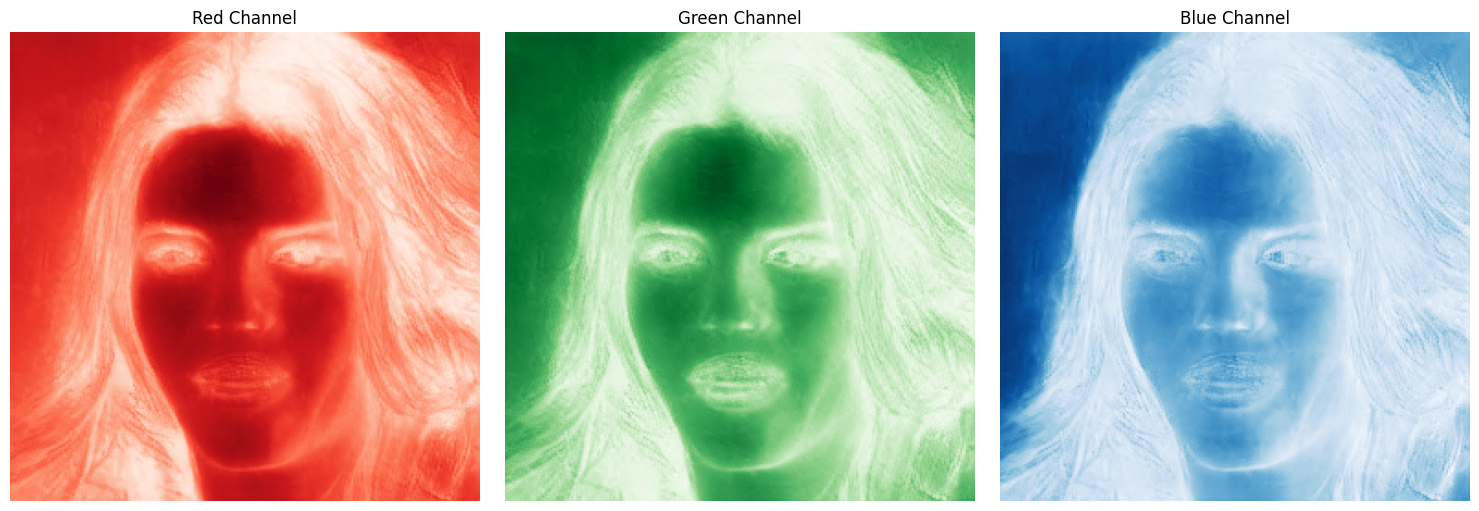

In [ ]:
import matplotlib.pyplot as plt

red_channel = image_processed[0, :, :, 0]
green_channel = image_processed[0, :, :, 1]
blue_channel = image_processed[0, :, :, 2]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(red_channel, cmap='Reds')
axes[0].set_title('Red Channel')
axes[0].axis('off')

axes[1].imshow(green_channel, cmap='Greens')
axes[1].set_title('Green Channel')
axes[1].axis('off')

axes[2].imshow(blue_channel, cmap='Blues')
axes[2].set_title('Blue Channel')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

img_min = image_processed.min()
img_max = image_processed.max()

image_norm = (image_processed - img_min) / (img_max - img_min)
image_norm = (image_norm * 255).astype(np.uint8)

plt.imshow(image_norm[0])

AttributeError: 'Tensor' object has no attribute 'astype'